# ARIMA
General process for ARIMA models:
- visualize the time series
- make the time series data stationary
- plot the correlation and autocorrelation charts
- construct the ARIMA model
- Use the model to make predictions

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [4]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [5]:
#cleaning data
df.columns = ['Month', 'Milk in Pounds per Cow']

In [6]:
df.head()

,Month,Milk in Pounds per Cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [7]:
#drop unneeded values
df.drop(168, axis = 0, inplace = True)

In [8]:
#turn into datetime index
df['Month'] = pd.to_datetime(df['Month'])

In [9]:
#set index as month
df.set_index('Month', inplace = True)

In [10]:
df.head()

,Milk in Pounds per Cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [12]:
#show additional information
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


# Step 2: Visualize Data

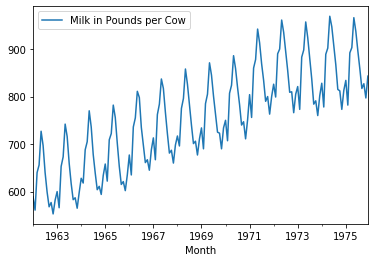

In [13]:
df.plot()

In [14]:
#turn into series
time_series = df['Milk in Pounds per Cow']

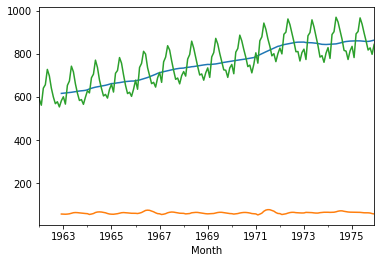

In [17]:
#12 month rolling mean avg
#separates trend from seasonality
time_series.rolling(12).mean().plot(label = '12 Month Rolling Mean')
#want std to be relatively flat
time_series.rolling(12).std().plot(label = '12 Month Rolling Std')

time_series.plot()

In [20]:
#ETS Decomposition
#separates trend, seasonality, and residual
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
decomp = seasonal_decompose(time_series)

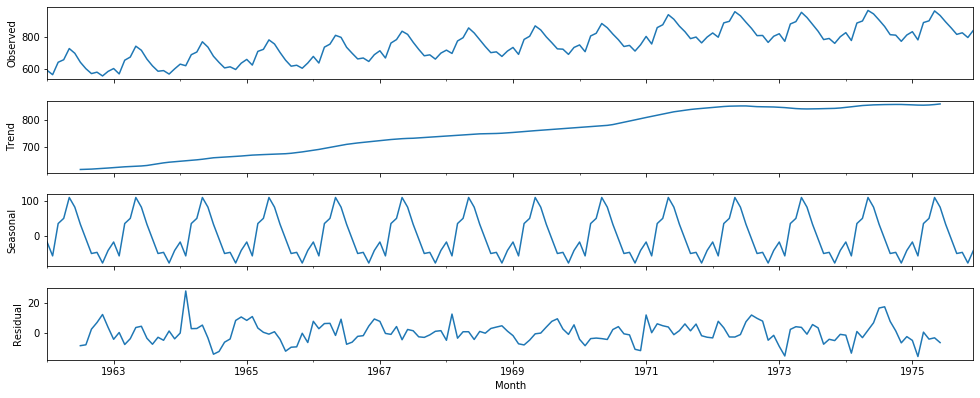

In [25]:
r = decomp.plot()
r.set_size_inches(15,6)
#Upward Trend
#Seasonality is yearly

In [27]:
from statsmodels.tsa.stattools import adfuller

In [28]:
result = adfuller(df['Milk in Pounds per Cow'])

In [52]:
def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fullet Test")
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of observations used']
    for value, label in zip(result, labels):
        print(label+ " : "+str(value) )
            
    if result[1]<= 0.05:
        print('Evidence against null hypothesis')
        print('reject null hypothesis')
        print('Strong evidence it is stationary')
    else:
        print('weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root, it is non-stationary')

In [53]:
adf_check(df['Milk in Pounds per Cow'])

Augmented Dicky-Fullet Test
ADF Test Statistic : -1.3038115874221294
p-value : 0.6274267086030316
# of lags : 13
Num of observations used : 154
weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


In [54]:
#find stationary dataset to work with
#compare differences in time interval
df['First Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(1)

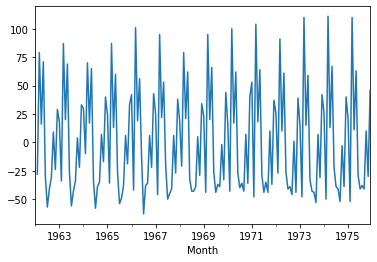

In [55]:
df['First Difference'].plot()

In [56]:
adf_check(df['First Difference'].dropna())

Augmented Dicky-Fullet Test
ADF Test Statistic : -3.0549955586530704
p-value : 0.030068004001785647
# of lags : 14
Num of observations used : 152
Evidence against null hypothesis
reject null hypothesis
Strong evidence it is stationary


In [57]:
#Second Difference
df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)

In [58]:
adf_check(df['Second Difference'].dropna())

Augmented Dicky-Fullet Test
ADF Test Statistic : -14.327873645603301
p-value : 1.1126989332084581e-26
# of lags : 11
Num of observations used : 154
Evidence against null hypothesis
reject null hypothesis
Strong evidence it is stationary


In [59]:
df['Seasonal Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(12)

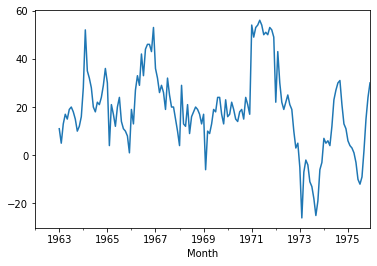

In [60]:
df['Seasonal Difference'].plot()

In [61]:
#Further in time variance increasing, not stationary
adf_check(df['Seasonal Difference'].dropna())

Augmented Dicky-Fullet Test
ADF Test Statistic : -2.335419314359398
p-value : 0.1607988052771135
# of lags : 12
Num of observations used : 143
weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


In [62]:
#Seasonal First Difference
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)

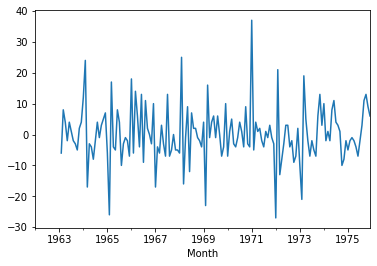

In [63]:
df['Seasonal First Difference'].plot()

In [64]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dicky-Fullet Test
ADF Test Statistic : -5.038002274921984
p-value : 1.8654234318788342e-05
# of lags : 11
Num of observations used : 143
Evidence against null hypothesis
reject null hypothesis
Strong evidence it is stationary


# AutoCorrelation

In [65]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

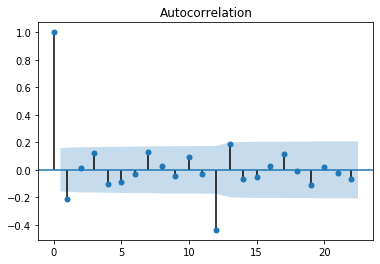

In [70]:
fig_first = plot_acf(df['Seasonal First Difference'].dropna())

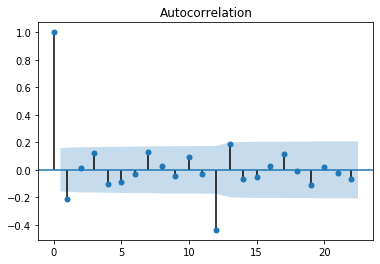

In [67]:
fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna())

In [68]:
from pandas.plotting import autocorrelation_plot

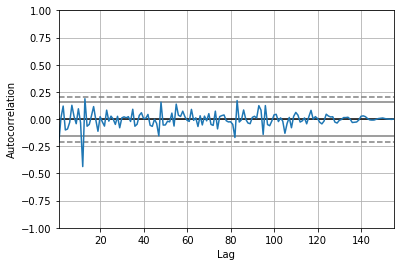

In [69]:
autocorrelation_plot(df['Seasonal First Difference'].dropna())

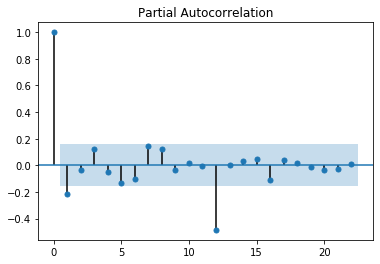

In [72]:
result = plot_pacf(df['Seasonal First Difference'].dropna())

# Forecasting with ARIMA

In [73]:
from statsmodels.tsa.arima_model import ARIMA

In [78]:
model = sm.tsa.statespace.SARIMAX(df['Milk in Pounds per Cow'], order = (0,1,0), seasonal_order = (1,1,1,12))

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [79]:
results = model.fit()

In [80]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Fri, 23 Oct 2020   AIC                           1074.131
Time:                                    17:38:03   BIC                           1083.261
Sample:                                01-01-1962   HQIC                          1077.839
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

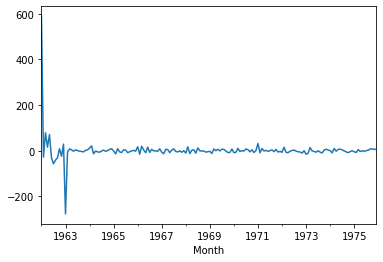

In [82]:
#Residual Error Values
results.resid.plot()

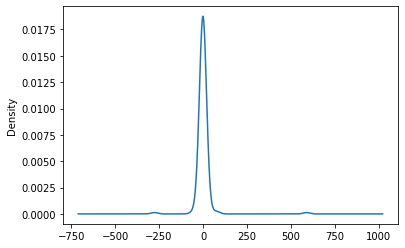

In [83]:
#kernel density estimation
#see distribution of errors
#closer errors are to 0 the better
results.resid.plot(kind = 'kde')

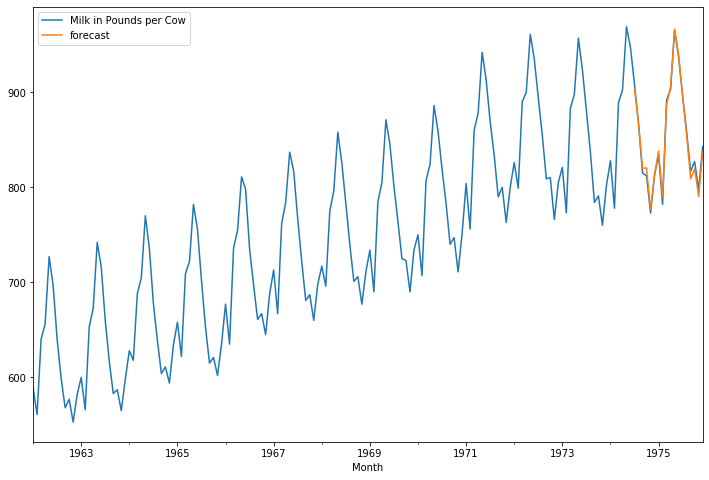

In [85]:
#Showing what Arima Model would have forecasted
#Compares closely to real data
#Good prediction, apart from certain seasons
df['forecast'] = results.predict(start = 150, end=168)
df[['Milk in Pounds per Cow', 'forecast']].plot(figsize=(12,8))

In [87]:
#Create more timeseries to forecast after end of used time series
from pandas.tseries.offsets import DateOffset

In [90]:
future_dates = [df.index[-1]+DateOffset(months = x)for x in range(1, 24)]

In [91]:
#2 years into future
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [93]:
#concatenate into original time series
future_df = pd.DataFrame(index=future_dates, columns = df.columns)

In [94]:
final_df = pd.concat([df, future_df])

In [96]:
final_df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
final_df['forecast'] = results.predict(start=168,end=192)

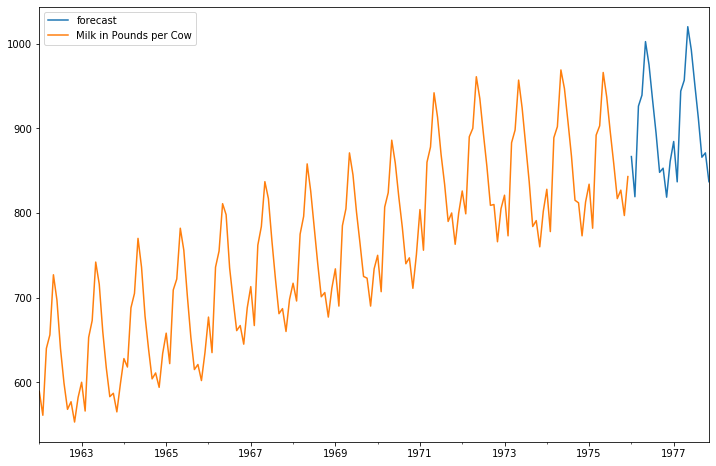

In [105]:
final_df[['forecast','Milk in Pounds per Cow']].plot(figsize=(12,8))